In [1]:
# Script to clean pre-process BIOMASS INVENTORY and make spatial

# First, load packages
import pandas as pd
import os
import numpy as np
import shapely as sp
import fiona

import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

import plotly.plotly as py

# only for jupyter nb to show plots inline
#%matplotlib inline 

print("*BIOMASS PREPROCESSING SCRIPT BEGINS*")

*BIOMASS PREPROCESSING SCRIPT BEGINS*


In [2]:
#check wd
#print(os.getcwd())

#change wd
os.chdir("/Users/anayahall/projects/grapevine")

#read in biomass inventory
# GROSS inventory
gbm = pd.read_csv("data/raw/biomass.inventory.csv")

# TECHNICAL inventory
tbm = pd.read_csv("data/raw/biomass.inventory.technical.csv")

In [3]:
gbm.head()
tbm.head()

gbm.columns

# check that all counties in there
len(gbm.COUNTY.unique())
#yup, plus one "other"

59

In [4]:
gbm['biomass.category'].value_counts()
# same as technical

row residue                               5900
row culls                                 4425
orchard vineyard residue                  3717
orchard vineyard culls                    3186
field residue                             2655
organic fraction municipal solid waste    2378
low moisture solids                       1947
high moisture solids                      1416
forestry                                   696
manure                                     177
Name: biomass.category, dtype: int64

In [5]:
gbm['biomass.feedstock'].value_counts().head()
# same as technical
# tbm['biomass.feedstock'].value_counts().head()

VEG OTHER         413
MELON             413
ASPARAGUS         413
CORN SWEET        413
SPICES & HERBS    413
Name: biomass.feedstock, dtype: int64

In [6]:
gbm[gbm['disposal.yields'] == gbm['disposal.yields'].max()]

,COUNTY,biomass.feedstock,disposal.yields,year,biomass.category
26027,Tulare,MANURE,2528938.639,2050,manure


In [7]:
#look at just manure (if feedstock, needs to be capitalized), if category, lower case -- should be equivalent!
gbm[(gbm['biomass.feedstock'] == "MANURE") & (gbm['year'] == 2014)].head()

,COUNTY,biomass.feedstock,disposal.yields,year,biomass.category
25856,Alameda,MANURE,30611.846700,2014,manure
25857,Alpine,MANURE,596.021083,2014,manure
25858,Amador,MANURE,28287.661520,2014,manure
25859,Butte,MANURE,31633.009850,2014,manure
25860,Calaveras,MANURE,30616.484900,2014,manure


In [8]:
#start grouping by: biomass category

gbm.groupby(['biomass.category'])['disposal.yields'].sum()

biomass.category
field residue                             5.670601e+06
forestry                                  8.363639e+07
high moisture solids                      2.878861e+06
low moisture solids                       1.527702e+07
manure                                    3.440785e+07
orchard vineyard culls                    5.222257e+05
orchard vineyard residue                  1.096371e+07
organic fraction municipal solid waste    6.297142e+07
row culls                                 1.573085e+06
row residue                               1.314184e+06
Name: disposal.yields, dtype: float64

In [9]:
gbm[gbm['biomass.category'] == "manure"].groupby(['COUNTY'])['disposal.yields'].sum().head()

COUNTY
Alameda      78386.468600
Alpine        1483.436603
Amador       71370.762600
Butte        83742.977030
Calaveras    81029.550070
Name: disposal.yields, dtype: float64

In [10]:
# now load shapefile for CA counties to merge this

#UScounties = fiona.open("data/raw/tl_2018_06_tract/tl_2018_06_tract.shp")
print("read in county shapefile")
CA = gpd.read_file("data/raw/tl_2018_06_tract/tl_2018_06_tract.shp")

read in county shapefile


In [36]:
CA.tail()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,FIPS
8052,06,059,001303,06059001303,13.03,Census Tract 13.03,G5020,S,1179651,0,+33.9209014,-117.9511671,"POLYGON ((-117.959174 33.92458, -117.958881 33...",6059
8053,06,059,001304,06059001304,13.04,Census Tract 13.04,G5020,S,1252716,0,+33.9244375,-117.9455411,"POLYGON ((-117.959178 33.928202, -117.958306 3...",6059
8054,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"POLYGON ((-117.950559 33.945034, -117.950555 3...",6059
8055,06,013,367200,06013367200,3672,Census Tract 3672,G5020,S,1322081,0,+37.9660279,-122.3355504,"POLYGON ((-122.345508 37.963547, -122.3455 37....",6013
8056,06,047,002402,06047002402,24.02,Census Tract 24.02,G5020,S,28084168,0,+36.9746245,-120.6220705,"POLYGON ((-120.658384 36.965939, -120.658328 3...",6047


In [12]:
# CREATE FIPS ID to merge with county names
#CAshape.FIPS = str(CAshape.STATEFP) + str(CAshape.COUNTYFP)
CA['FIPS']=CA['STATEFP'].astype(str)+CA['COUNTYFP']

# get rid of leading zero
CA.FIPS = [s.lstrip("0") for s in CA.FIPS]

#convert to integer for merging below
CA.FIPS = [int(i) for i in CA.FIPS]


In [13]:
# NEED TO BRING IN COUNTY NAMES TO MERGE WITH BIOMASS DATA
countyIDs = pd.read_csv("data/interim/CA_FIPS.csv", names = ["FIPS", "COUNTY", "State"])
countyIDs

type(countyIDs.FIPS[0])
type(CA.FIPS[0])

CAshape = pd.merge(CA, countyIDs, on = 'FIPS')

CAshape.head()


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,FIPS,COUNTY,State
0,06,037,137504,06037137504,1375.04,Census Tract 1375.04,G5020,S,3837562,0,+34.1480383,-118.5720594,"POLYGON ((-118.581186 34.143176, -118.580994 3...",6037,Los Angeles,CA
1,06,037,138000,06037138000,1380,Census Tract 1380,G5020,S,4472196,0,+34.1488008,-118.5910495,"POLYGON ((-118.60573 34.145854, -118.605611 34...",6037,Los Angeles,CA
2,06,037,139200,06037139200,1392,Census Tract 1392,G5020,S,1152031,0,+34.1756961,-118.5246447,"POLYGON ((-118.530824 34.180236, -118.529515 3...",6037,Los Angeles,CA
3,06,037,143200,06037143200,1432,Census Tract 1432,G5020,S,957093,0,+34.1494399,-118.3720618,"POLYGON ((-118.37899 34.154093, -118.378882 34...",6037,Los Angeles,CA
4,06,037,143300,06037143300,1433,Census Tract 1433,G5020,S,1649223,5619,+34.1521830,-118.3866139,"POLYGON ((-118.396484 34.157614, -118.395377 3...",6037,Los Angeles,CA


In [14]:
type(CAshape)

geopandas.geodataframe.GeoDataFrame

In [28]:
# now can merge with biomass data finally!!!
gbm.columns
print("merging biomass data with CA shapefile")

gbm_shp = pd.merge(CAshape, gbm, on = 'COUNTY')

# Do same for technical biomass
tbm_shp = pd.merge(CAshape, tbm, on = 'COUNTY')


merging biomass data with CA shapefile


In [34]:
type(tbm_shp)
tbm_shp.tail()


gbm_shp[gbm_shp['biomass.category'] == "manure"].groupby(['COUNTY'])['disposal.yields'].sum().head()

COUNTY
Alameda      2.829752e+07
Alpine       1.483437e+03
Amador       6.423369e+05
Butte        4.270892e+06
Calaveras    8.102955e+05
Name: disposal.yields, dtype: float64

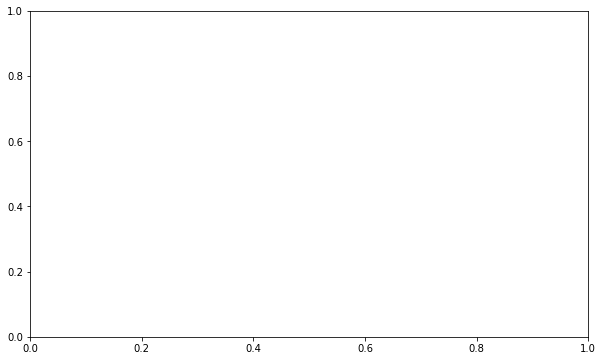

In [25]:
# # play around with plotting ??? COME BACK TO
# gbm['disposal.yields']

# # set a variable that will call whatever column we want to visualise on the map
# variable = "disposal.yields"
# # set the range for the choropleth
# vmin, vmax = 100, 2500000
# # create figure and axes for Matplotlib
# fig, ax = plt.subplots(1, figsize=(10, 6))

In [35]:
print("DONE RUNNING -- come back to play with grouping and/or plotting")

DONE RUNNING -- come back to play with grouping and/or plotting
